# Canonicalizing Networks

In this project we shall be trying to establish canonicalization of networks to establish equivalence class of neural networks. We shall be extending this work to deep neural networks (including convolutional networks) in later stage of the project. 

Datasets: CIFAR10; when we extend this to deep networks we will look at the possibility of using the ImageNet dataset.

Method:
1. Split the **traindata** into **three** parts (for now we show only on three networks, will extend to more networks).
2. Build the three networks using same hyperparameters. 
3. **Fix** the first network. Let us call this as, network *A*. 
4. We modify the other two networks so that they look as close to *A* as possible. Validate that the alterations have been consistent throughout the network such that the networks are giving the same outputs.
5. Now combine networks *B* and *C* using $\alpha$ and $(1-\alpha)$ and create a new network. Investigate on its performance. (**done till here**)
6. Establish a **distance kernel** *K*. Use *k* to tell if two networks can be equal. $\texttt{Try to use graph kernels here}$.

Network type (architectures):
1. Begin with a simple two layer network (can extend to *n* layers, including *convolution* layers).
2. $\texttt{fc $\times$ ReLU $\times$ BN $\times$ Drop_out $\times$ fc $\times$ softmax}$
3. $\texttt{fc $\times$ ReLU $\times$ Drop_out $\times$ fc $\times$ softmax}$

# Setting up stuff

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from src.classifiers.fc_net import *
from src.data_utils import get_CIFAR10_data
from src.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from src.solver import Solver
from src.canonicalize import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


In [3]:
# splitting up the train data

X_train = data['X_train']
y_train = data['y_train']

total_train_size = X_train.shape[0]
full_indices = np.random.permutation(total_train_size)

mask1 = range(total_train_size/3)
X_train1 = X_train[full_indices[mask1]]
y_train1 = y_train[full_indices[mask1]]

mask2 = range(total_train_size/3, 2*total_train_size/3)
X_train2 = X_train[full_indices[mask2]]
y_train2 = y_train[full_indices[mask2]]

mask3 = range(2*total_train_size/3, 3*total_train_size/3)
X_train3 = X_train[full_indices[mask3]]
y_train3 = y_train[full_indices[mask3]]

data1 = {
        'X_train': X_train1, 'y_train' : y_train1,
        'X_val': data['X_val'], 'y_val' : data['y_val'],
        'X_test': data['X_test'], 'y_test' : data['y_test'],
        }
data2 = {
        'X_train': X_train2, 'y_train' : y_train2,
        'X_val': data['X_val'], 'y_val' : data['y_val'],
        'X_test': data['X_test'], 'y_test' : data['y_test'],
        }
data3 = {
        'X_train': X_train3, 'y_train' : y_train3,
        'X_val': data['X_val'], 'y_val' : data['y_val'],
        'X_test': data['X_test'], 'y_test' : data['y_test'],
        }

# Solver1

Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [65]:
best_model1 = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
# here I use the same parameters I got before, seems like they perform moderately fine
model1 = FullyConnectedNet([100, 100], weight_scale=0.0025, use_batchnorm = False, reg=0.01)
solver1 = Solver(model1, data1,
                        print_every=data1['X_train'].shape[0], num_epochs=100, batch_size=100,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': 0.0025,
                        },verbose=True, lr_decay = 0.9,
                 )
solver1.train()
best_model1 = model1
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 16300) loss: 2.312382
(Epoch 0 / 100) train acc: 0.113000; val_acc: 0.107000
(Epoch 1 / 100) train acc: 0.163000; val_acc: 0.160000
(Epoch 2 / 100) train acc: 0.235000; val_acc: 0.249000
(Epoch 3 / 100) train acc: 0.277000; val_acc: 0.298000
(Epoch 4 / 100) train acc: 0.334000; val_acc: 0.344000
(Epoch 5 / 100) train acc: 0.354000; val_acc: 0.377000
(Epoch 6 / 100) train acc: 0.384000; val_acc: 0.378000
(Epoch 7 / 100) train acc: 0.427000; val_acc: 0.403000
(Epoch 8 / 100) train acc: 0.404000; val_acc: 0.417000
(Epoch 9 / 100) train acc: 0.429000; val_acc: 0.429000
(Epoch 10 / 100) train acc: 0.458000; val_acc: 0.446000
(Epoch 11 / 100) train acc: 0.463000; val_acc: 0.441000
(Epoch 12 / 100) train acc: 0.480000; val_acc: 0.429000
(Epoch 13 / 100) train acc: 0.467000; val_acc: 0.451000
(Epoch 14 / 100) train acc: 0.483000; val_acc: 0.460000
(Epoch 15 / 100) train acc: 0.476000; val_acc: 0.443000
(Epoch 16 / 100) train acc: 0.512000; val_acc: 0.464000
(Epoch 17 / 100) trai

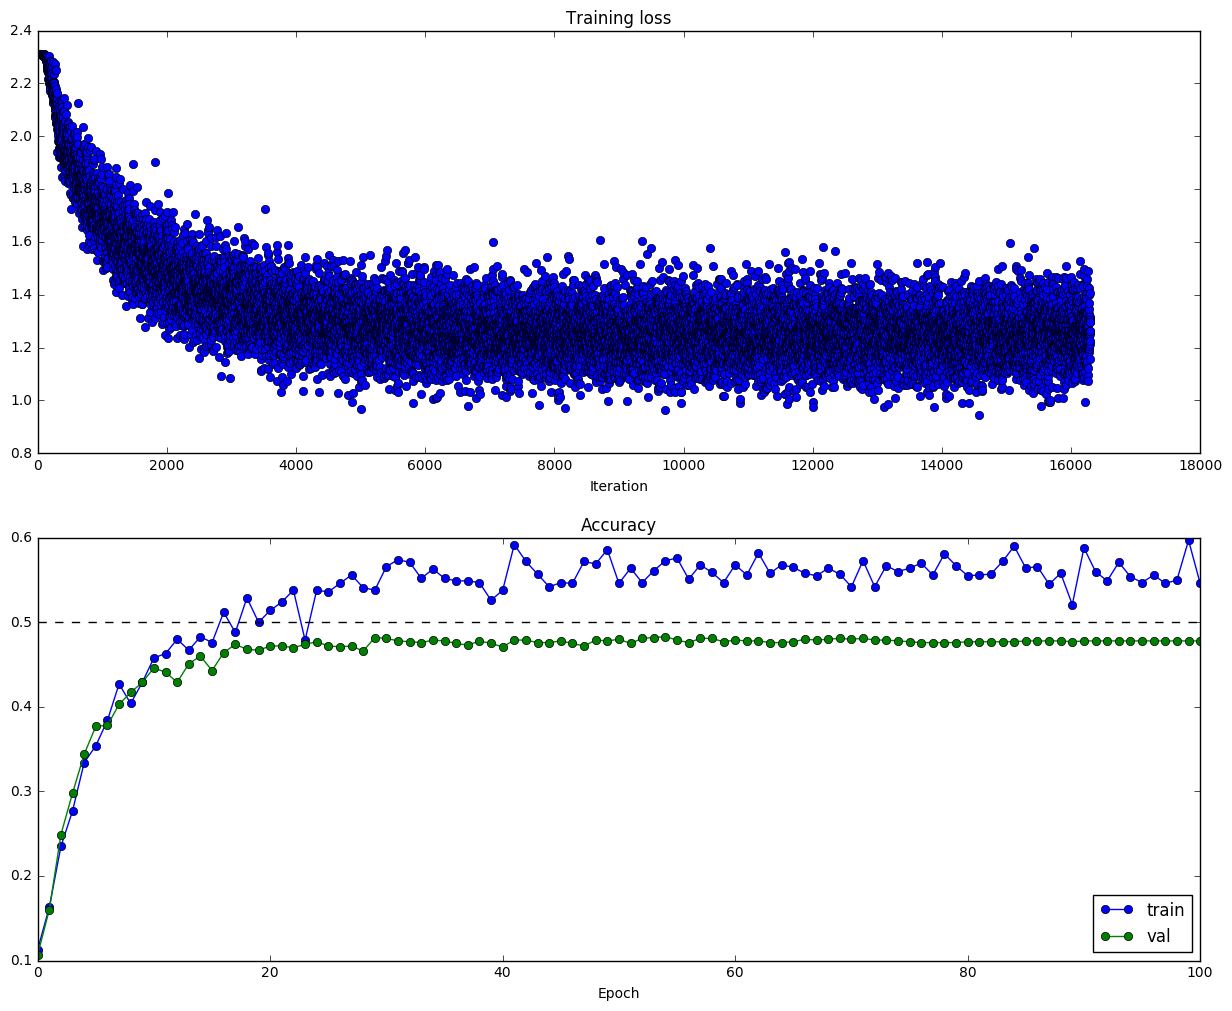

In [66]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver1.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver1.train_acc_history, '-o', label='train')
plt.plot(solver1.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver1.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Solver2

Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [68]:
best_model2 = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
# here I use the same parameters I got before, seems like they perform moderately fine
model2 = FullyConnectedNet([100, 100], weight_scale=0.0025, use_batchnorm = False, reg=0.01)
solver2 = Solver(model2, data1,
                        print_every=data1['X_train'].shape[0], num_epochs=100, batch_size=100,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': 0.0025,
                        },verbose=True, lr_decay = 0.9,
                 )
solver2.train()
best_model2 = model2
pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 16300) loss: 2.313041
(Epoch 0 / 100) train acc: 0.098000; val_acc: 0.118000
(Epoch 1 / 100) train acc: 0.158000; val_acc: 0.134000
(Epoch 2 / 100) train acc: 0.195000; val_acc: 0.224000
(Epoch 3 / 100) train acc: 0.274000; val_acc: 0.272000
(Epoch 4 / 100) train acc: 0.312000; val_acc: 0.323000
(Epoch 5 / 100) train acc: 0.330000; val_acc: 0.356000
(Epoch 6 / 100) train acc: 0.370000; val_acc: 0.377000
(Epoch 7 / 100) train acc: 0.403000; val_acc: 0.392000
(Epoch 8 / 100) train acc: 0.440000; val_acc: 0.403000
(Epoch 9 / 100) train acc: 0.418000; val_acc: 0.414000
(Epoch 10 / 100) train acc: 0.456000; val_acc: 0.437000
(Epoch 11 / 100) train acc: 0.455000; val_acc: 0.454000
(Epoch 12 / 100) train acc: 0.433000; val_acc: 0.432000
(Epoch 13 / 100) train acc: 0.474000; val_acc: 0.437000
(Epoch 14 / 100) train acc: 0.490000; val_acc: 0.445000
(Epoch 15 / 100) train acc: 0.490000; val_acc: 0.446000
(Epoch 16 / 100) train acc: 0.498000; val_acc: 0.451000
(Epoch 17 / 100) trai

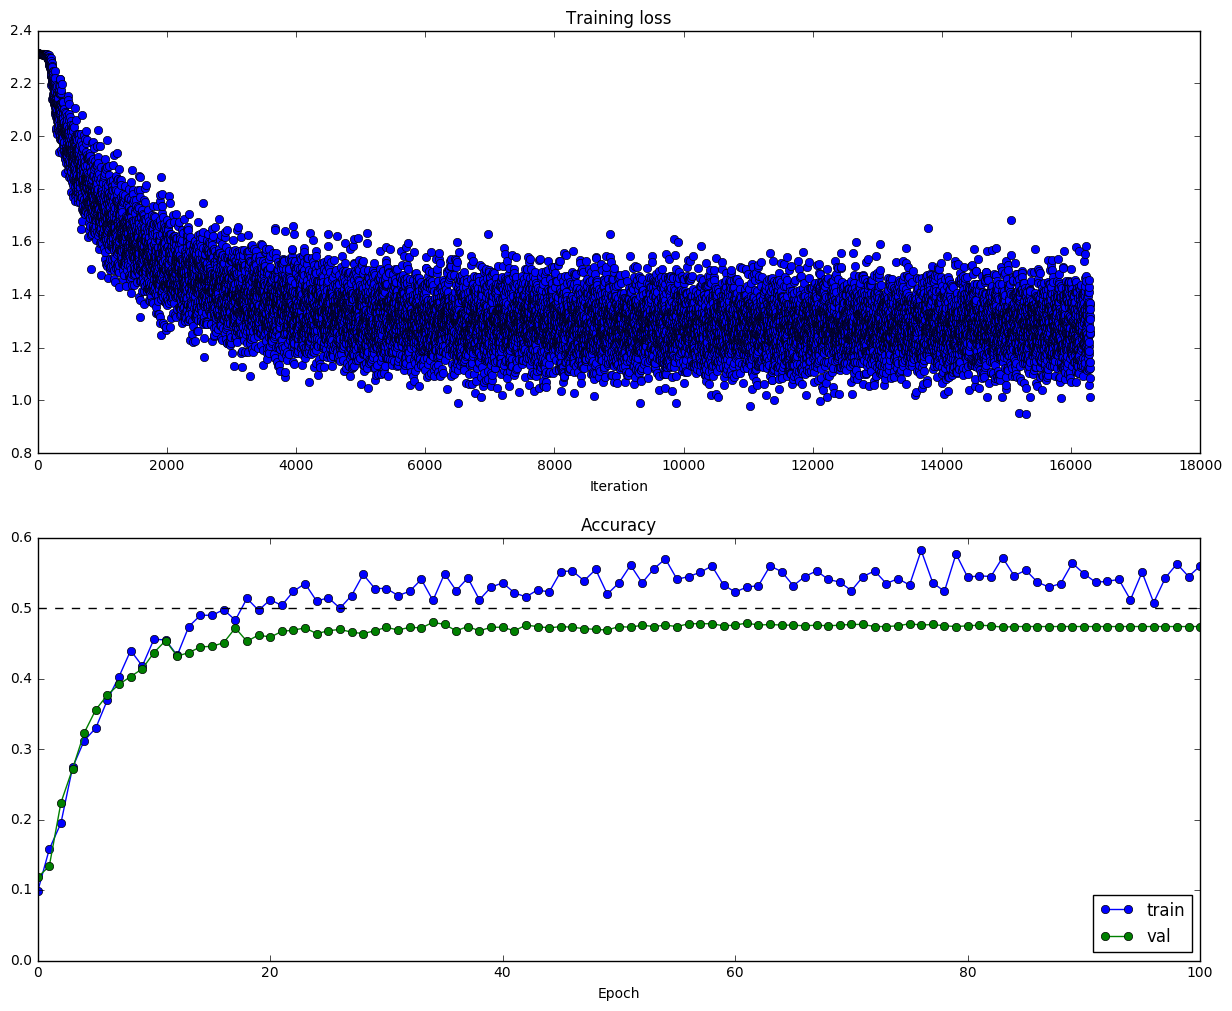

In [69]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver2.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver2.train_acc_history, '-o', label='train')
plt.plot(solver2.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver1.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

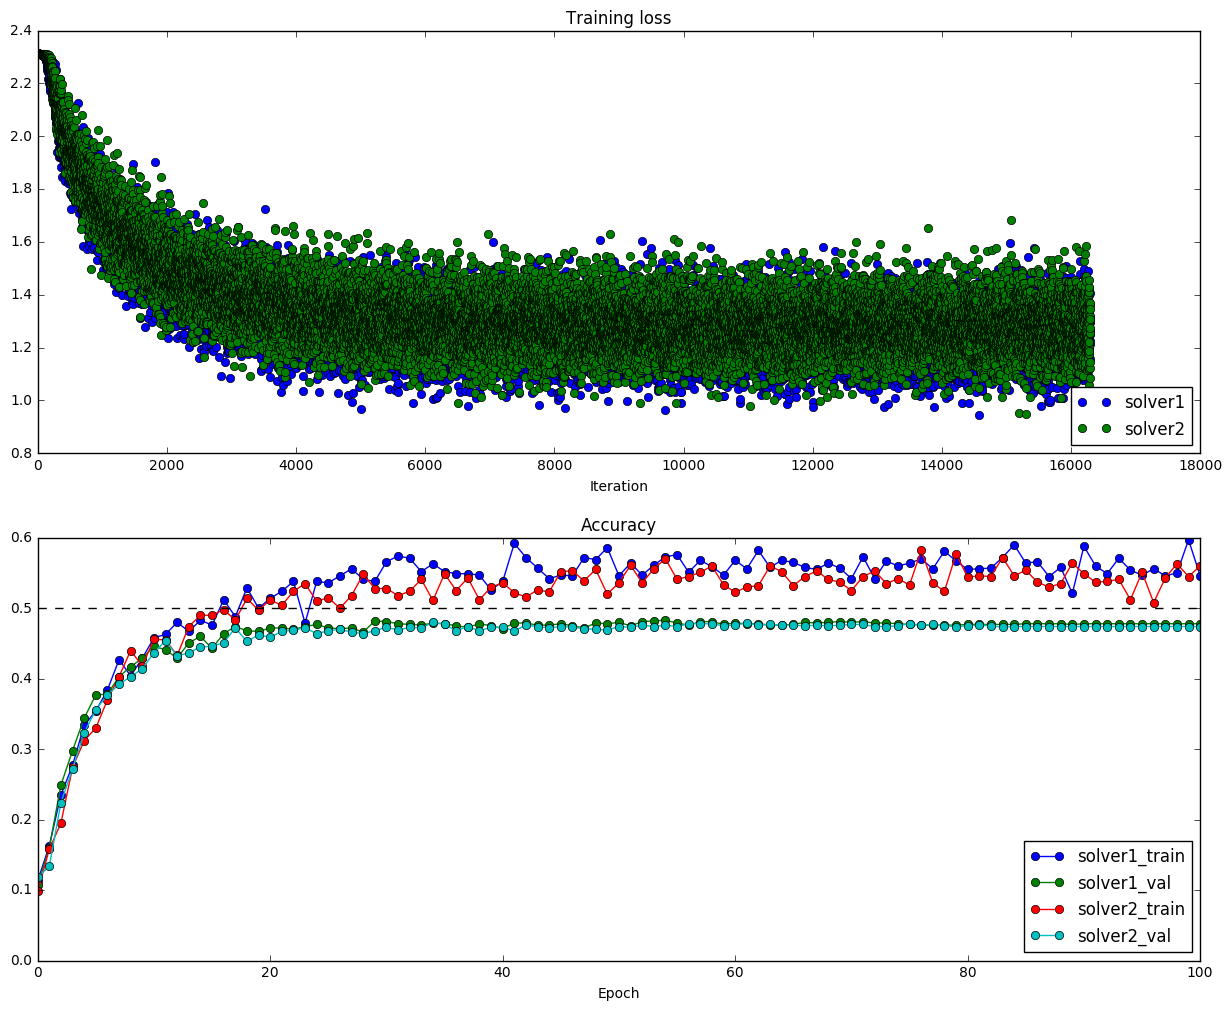

In [78]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver1.loss_history, 'o', label='solver1')
plt.plot(solver2.loss_history, 'o', label='solver2')
#plt.plot(solver3.loss_history, 'o', label='solver3')
plt.legend(loc='lower right')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver1.train_acc_history, '-o', label='solver1_train')
plt.plot(solver1.val_acc_history, '-o', label='solver1_val')
plt.plot(solver2.train_acc_history, '-o', label='solver2_train')
plt.plot(solver2.val_acc_history, '-o', label='solver2_val')
#plt.plot(solver3.train_acc_history, '-o', label='solver3_train')
#plt.plot(solver3.val_acc_history, '-o', label='solver3_val')
plt.plot([0.5] * len(solver1.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.savefig('Loss_accuracy_before_canonicalizaton.png', dpi=300)
plt.show()

# Rest

We have finally created three networks which sync with each other in similar fashion. The next step would be canonicalizing them

# Canonicalizing networks 2 and 3

In the following section we shall be canonicalizing two networks, so that they look as similar to network 1 as possible. This would make the ground work before we go ahead and show the combination of networks working in very similar fashion

In [86]:
# canonicalizing using hungarian
from src.canonicalize import *
from src.required_funcs import *

model1p = deepcopy(model1)
model2p = deepcopy(model2)

indices = match_vals(model1p, model2p, method='Hungarian')
model2c = canon_nets(model2p, indices.astype(int), use_batchnorm = False)

In [87]:
# canonicalizing using greedy
from src.canonicalize import *
from src.required_funcs import *

model1p = deepcopy(model1)
model2p = deepcopy(model2)

indices = match_vals(model1p, model2p, method='greedy')
model2c_greedy = canon_nets(model2p, indices.astype(int), use_batchnorm = False)

# Test the canonicalization 1

The tests are done to ensure that the canonicalization worked fine. The error for the first layer shall be considerably large, but would drastically decrease to less than 0 in the second and third layer

In [88]:
# checking accuracy for hungarian
'''
from src.net_checker import *

check_fun(data2, model2, model2c, use_batchnorm=False)
'''

Test accuracy after one swap:  640.395625392
Test accuracy after two swaps:  0.0101625514179
Test accuracy after final swaps:  0.00323007445222


In [89]:
# checking accuracy using greedy
'''
from src.net_checker import *

check_fun(data2, model2, model2c_greedy, use_batchnorm=False)
'''

Test accuracy after one swap:  968.98036284
Test accuracy after two swaps:  0.0100396370781
Test accuracy after final swaps:  0.00302632740735


# Check accuracy on validation sets

This would ensure that the new models behave consistently as compared to the old one.

In [90]:
# test implementation on validation sets for hungarian and greedy
'''
y_val_pred = np.argmax(model2c_greedy.loss(data1['X_val']), axis=1)
res3 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res3

y_val_pred = np.argmax(model2c.loss(data1['X_val']), axis=1)
res2 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res2

y_val_pred = np.argmax(model2.loss(data1['X_val']), axis=1)
res1 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res1
'''

Validation set accuracy for new:  0.48
Validation set accuracy for new:  0.48


# Model combinations

Since we have been able to canonicalize the two nets we now need to check if a mere average of the two networks work better than the canonicalizations. We first chech with fixed $\alpha = 0.5$.

In [92]:
# mixing with alpha = 0.5 for original two models
from src.creator import *

alpha = 0.5
new_model = create_model(model1, model2, alpha)
# test implementation on validation sets
y_val_pred = np.argmax(new_model.loss(data1['X_val']), axis=1)
print (y_val_pred == data1['y_val']).mean()

0.337


In [93]:
# mixing with alpha = 0.5 for new model-hungarian and model1
from src.creator import *

alpha = 0.5
new_model = create_model(model1, model2c, alpha)
# test implementation on validation sets
y_val_pred = np.argmax(new_model.loss(data1['X_val']), axis=1)
print (y_val_pred == data1['y_val']).mean()

0.332


In [94]:
# mixing with alpha = 0.5 for new model-greedy and model1
from src.creator import *

alpha = 0.5
new_model_greedy = create_model(model1, model2c_greedy, alpha)
# test implementation on validation sets
y_val_pred = np.argmax(new_model_greedy.loss(data1['X_val']), axis=1)
print (y_val_pred == data1['y_val']).mean()

0.359


# Model accuracies

Once the code passed all the previous checks, we proceed to check for all values of $\alpha$. For this we need a baseline. This baseline shall be obtained from the trained and the derived models

In [106]:
# check accuracy for model 1 and model2c (Hunagrian) and model2c_greedy
y_val_pred = np.argmax(model2c.loss(data1['X_val']), axis=1)
res2 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res2

y_val_pred = np.argmax(model1.loss(data1['X_val']), axis=1)
res1 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res1

y_val_pred = np.argmax(model2c_greedy.loss(data1['X_val']), axis=1)
res3 = (y_val_pred == data1['y_val']).mean()
print 'Validation set accuracy for new: ', res3

Validation set accuracy for new:  0.48
Validation set accuracy for new:  0.483
Validation set accuracy for new:  0.48


# Convex combinations of similar networks

We now begin to check how convex combination of two similarly converged network performs. For this we though need to choose for an $\alpha$ such that $\alpha = [0,1]$.

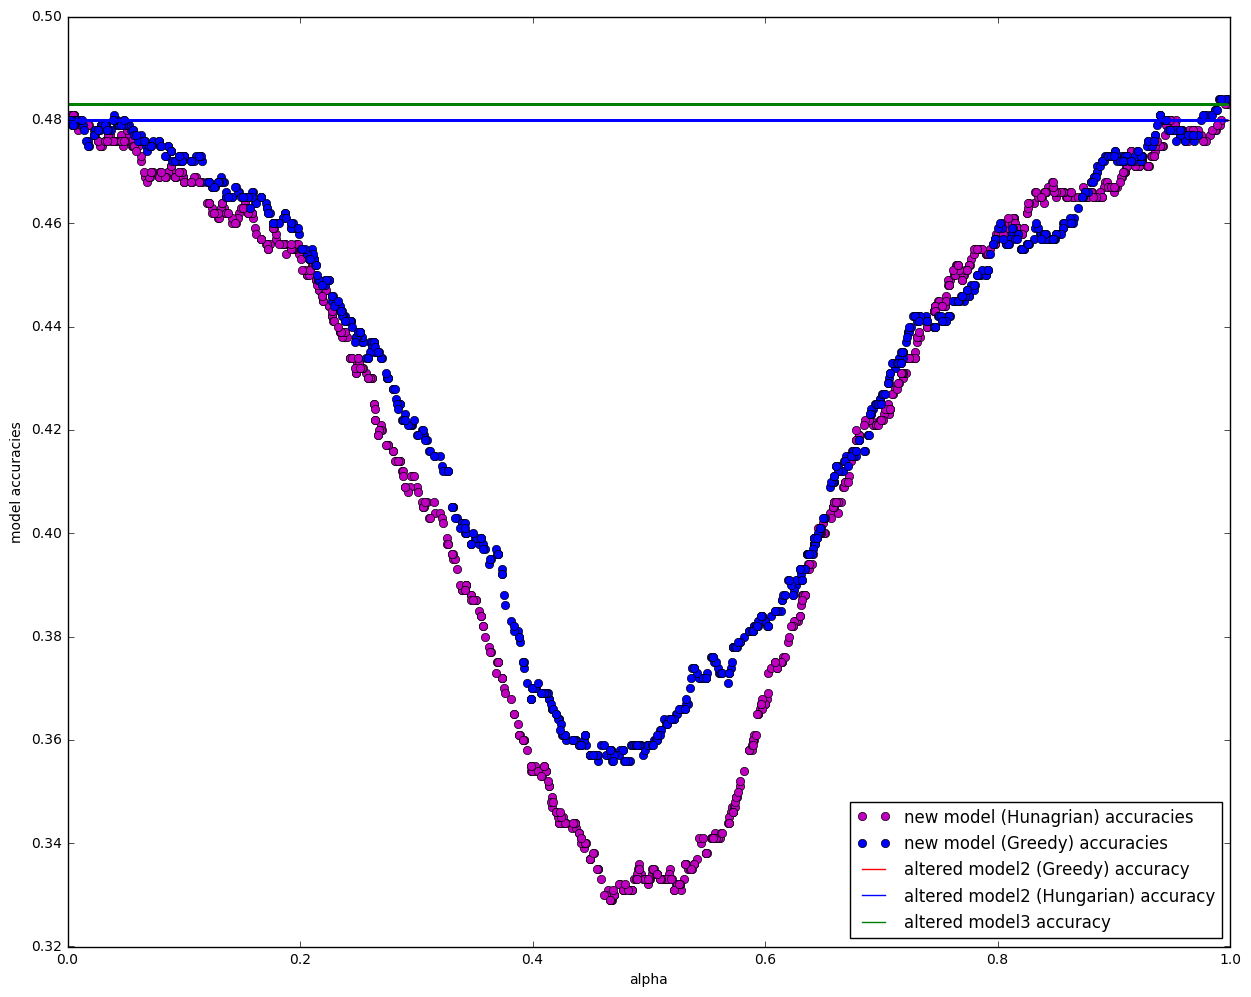

In [109]:
# once we have canonicalized two networks we choose \alpha as a real between zero and 1 and try to generate new networks
# hungarian and greedy both models are considered
import random
from src.creator import *

alpha = np.zeros(1000)
res_hun = np.zeros(1000)
res_gred = np.zeros(1000)
res3 = np.ones(1000)*res3
res2 = np.ones(1000)*res2
res1 = np.ones(1000)*res1
for i in range(1000):
    alpha[i] = random.random()
    new_model_hungarian = create_model(model1, model2c, alpha[i])
    new_model_greedy = create_model(model1, model2c_greedy, alpha[i])
    # test implementation on validation sets
    y_val_pred_hungarian = np.argmax(new_model_hungarian.loss(data1['X_val']), axis=1)
    res_hun[i] = (y_val_pred_hungarian == data1['y_val']).mean()
    
    y_val_pred_greedy = np.argmax(new_model_greedy.loss(data1['X_val']), axis=1)
    res_gred[i] = (y_val_pred_greedy == data1['y_val']).mean()
    
plt.plot(alpha, res_hun, 'mo', label='new model (Hunagrian) accuracies')
plt.plot(alpha, res_gred, 'o', label='new model (Greedy) accuracies')
plt.plot(alpha, res3, '-r', label='altered model2 (Greedy) accuracy')
plt.plot(alpha, res2, '-b', label='altered model2 (Hungarian) accuracy')
plt.plot(alpha, res1, '-g', label='altered model3 accuracy')
plt.xlabel('alpha')
plt.ylabel('model accuracies')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.savefig('New_model_accuracy_vs_alpha.png', dpi=300)
plt.show()

# Visualizing weights

We now try to visualize the weights and see if we can fid similarities

model1 W1 visualizations


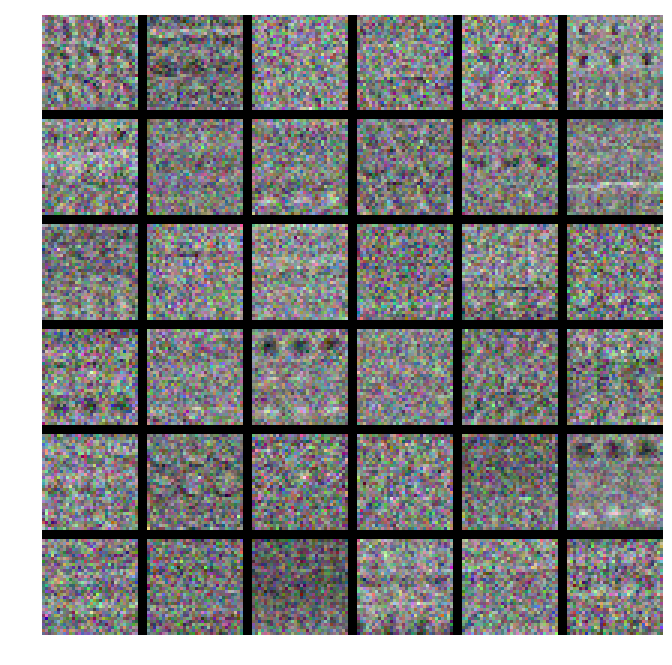

model2 W1 visualizations


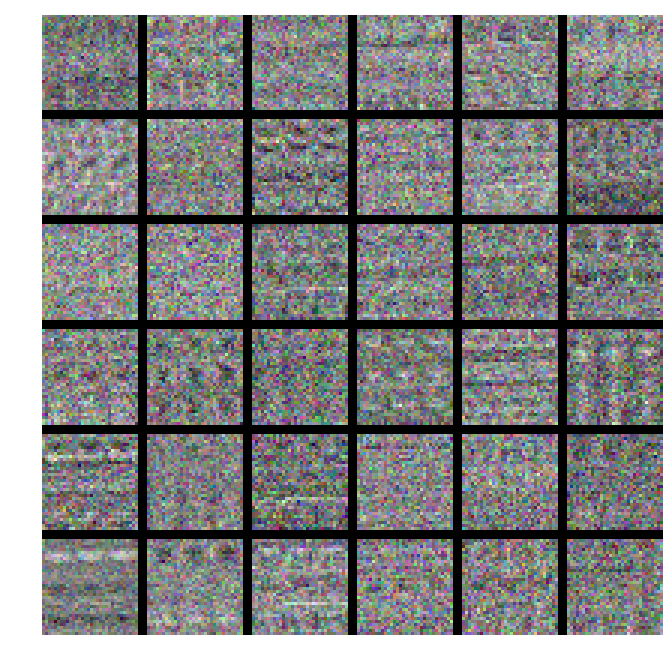

model2c (Hungarian) W1 visualizations


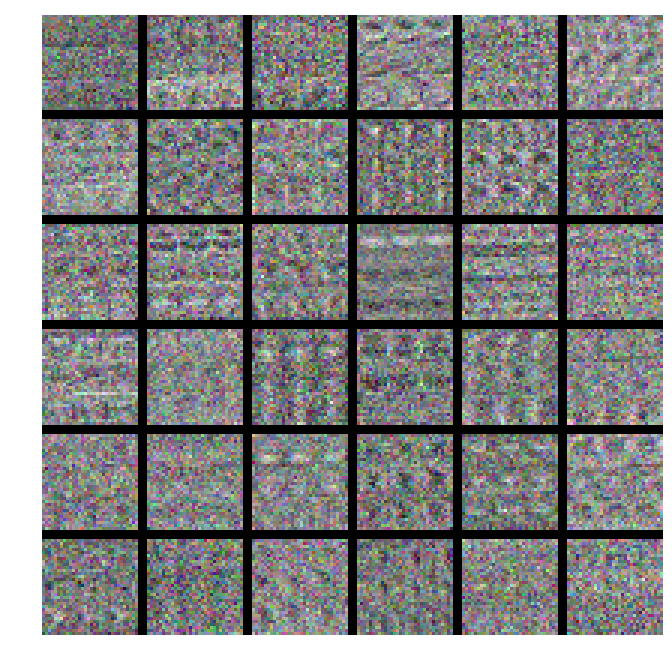

model2c (Greedy) W1 visualizations


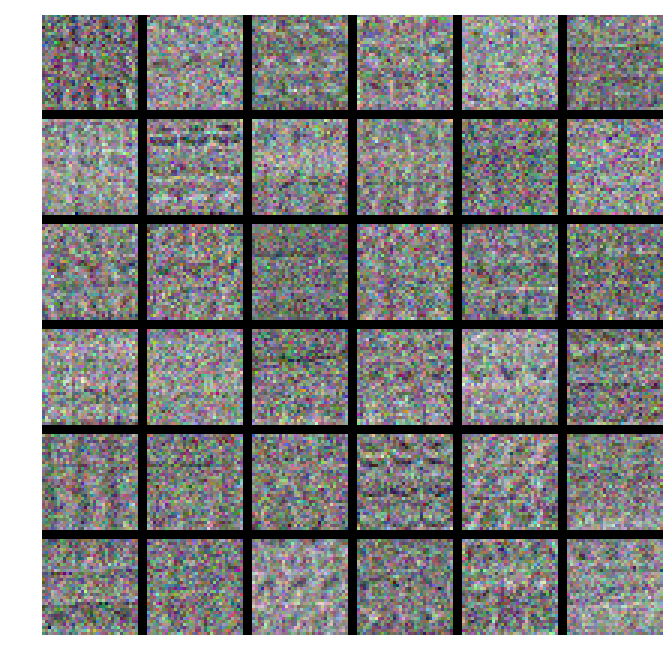

In [108]:
# visualizing the weights
import random
from src.vis_utils import visualize_grid

def show_net_weights(net, ids, name):
    ext = '.png'
    W1 = net.params['W1'][:,ids]
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.savefig(name+ext, dpi=300)
    plt.show()

ids = random.sample(range(1, model1.params['W1'].shape[1]), 36)
print "model1 W1 visualizations"
show_net_weights(model1, ids, 'model1')
print "model2 W1 visualizations"
show_net_weights(model2, ids, 'model2')
print "model2c (Hungarian) W1 visualizations"
show_net_weights(model2c, ids, 'model2c')
print "model2c (Greedy) W1 visualizations"
show_net_weights(model2c_greedy, ids, 'model2c_greedy')

# Testing

Run the models on the test set

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()